In [2]:
using Pkg
if Sys.KERNEL == :Linux
    environment = "../stoch_growth_model_server"
elseif Sys.KERNEL == :Darwin
    environment = "AAA - Honours Projec/stoch_growth_model_for_alice/"
end
    
Pkg.activate("$environment")

  Activating project at `~/stoch_growth_model_for_alice/stoch_growth_model_server`


In [ ]:
# Pkg.add(PackageSpec(name="Catalyst", version="15.0.4"))
# Pkg.add(PackageSpec(name="DifferentialEquations", version="7.16.1"))
# Pkg.add(PackageSpec(name="DataFrames", version="1.7.0"))
# Pkg.add(PackageSpec(name="CSV", version="0.10.15"))
# Pkg.add("Plots")


In [3]:
using Catalyst
using DifferentialEquations
using DataFrames
using CSV
using Plots

In [10]:
include("model_eqs_tutorial.jl")
include("model_div_tutorial.jl")
include("../src/setup_funcs.jl")
params = getPars("molecs", "PNAs"; abx=0.0)
u0 = getX0(gm_divC; ss=false, parametrization="PNAs")

18-element Vector{Pair{Num, Float64}}:
   a(t) => 10.0
  si(t) => 0.0
  mm(t) => 0.0
  mt(t) => 0.0
  mq(t) => 0.0
  mr(t) => 0.0
  cm(t) => 0.0
  ct(t) => 0.0
  cq(t) => 0.0
  cr(t) => 0.0
  em(t) => 0.0
  et(t) => 0.0
   q(t) => 0.0
   r(t) => 10.0
 zmm(t) => 0.0
 zmt(t) => 0.0
 zmq(t) => 0.0
 zmr(t) => 0.0

In [11]:
println("Solving ODE system")
# prob = ODEProblem(gm_divC, u0, (0.0, 1e3), params)
# sol = solve(prob, Rodas5(); saveat=1.0)

# prob = ODEProblem(gm_divC, u0, (1e-3, 1e9), params)
# sol = solve(prob, Rodas5(); saveat=10 .^ range(-3, 9; length=500))

tspan = (1e-3, 1e9)
save_times = 10 .^ range(-3, 9; length=500)
prob = ODEProblem(gm_divC, u0, tspan, params)
sol = solve(prob, Rodas5(); saveat=save_times)

println("Simulation complete")


Solving ODE system
Simulation complete


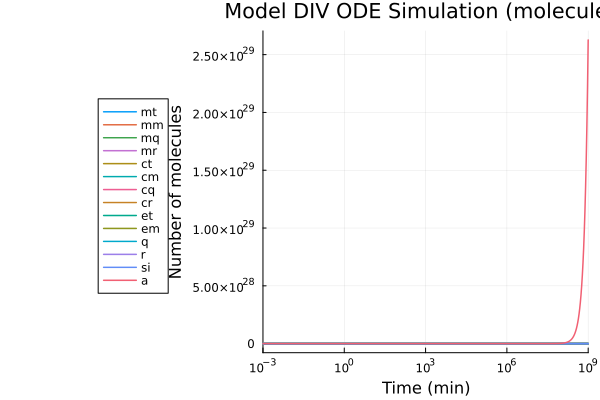

In [12]:
include("model_div_tutorial.jl")   # defines gm_divC

# Pick ONE parameterization & units. If you want molecule counts, do this:
params = getPars("molecs", "PNAs"; abx=0.0)
u0     = getX0(gm_divC; ss=false, parametrization="PNAs")

t      = 10 .^ range(-3, 9; length=500)
prob   = ODEProblem(gm_divC, u0, (t[1], t[end]), params)
sol    = solve(prob, Rodas5(); saveat=t)

# Plot ONLY the species you care about (no DataFrame, no implicit columns)
species_to_plot = [:mt,:mm,:mq,:mr,:ct,:cm,:cq,:cr,:et,:em,:q,:r,:si,:a]
plot(sol; idxs=species_to_plot, xscale=:log10, lw=1.5,
     xlabel="Time (min)", ylabel="Number of molecules",
     legend=:outerleft, title="Model DIV ODE Simulation (molecules)")

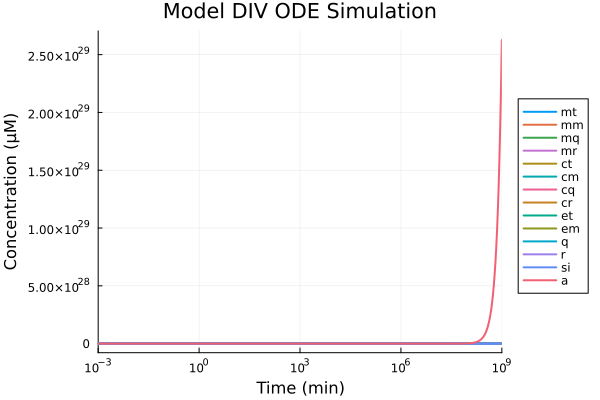

In [6]:

df = DataFrame(sol)
#CSV.write("model_div_results.csv", df)
μM_to_molecules = 1e-6 * 6.02214076e23 * 1e-15  # (μM) × Avogadro × cell volume (1 fL)

# plot(sol * μM_to_molecules; idxs=[:mt, :mm, :mq, :mr, :ct, :cm, :cq, :cr, :et, :em, :q, :r, :si, :a],
#      xscale=:log10, lw=1.5,
#      xlabel="Time (min)", ylabel="Number of molecules",
#      legend=:outerleft, title="Model DIV ODE Simulation (molecules)")
plt = plot(sol;
    idxs=[:mt, :mm, :mq, :mr, :ct, :cm, :cq, :cr, :et, :em, :q, :r, :si, :a],
    lw=2,
    xlabel="Time (min)",
    ylabel="Concentration (µM)",
    legend=:outerright,
    title="Model DIV ODE Simulation",
    xscale=:log10    # <-- this gives you the log time axis
)
display(plt)


In [12]:
# To save changes each time
# in a server terminal: 
# git add . 
# git commit -m "message"
# git push


# If working somewhere else do: git pull

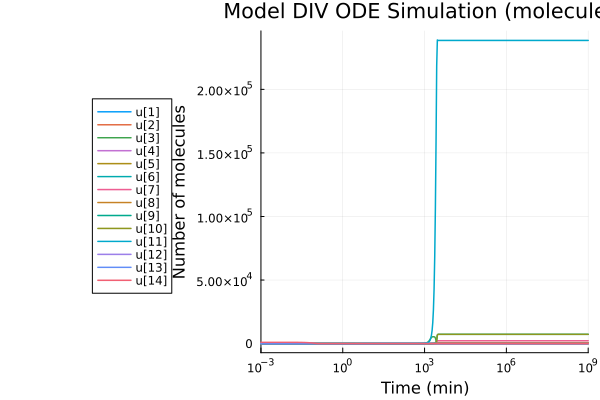

In [14]:
using DifferentialEquations
using Plots

# ⚙️ Define helper functions
function deg(x, dm)
    return x * dm
end

function r_b(mx, r, kb)
    return kb * mx * r
end

function r_ub(cx, ku)
    return cx * ku
end

function tx(w, theta, a; q=nothing, Kq=nothing, nq=nothing)
    if q !== nothing && Kq !== nothing && nq !== nothing
        return (w * a / (theta + a)) / (1 + (q / Kq)^nq)
    else
        return w * a / (theta + a)
    end
end

function tlr(a, nx, cx, gmax, Kgamma)
    gamma = gmax * a / (Kgamma + a)
    return (gamma / nx) * cx
end

function ttrate(a, cr, ct, cm, cq, gmax, Kgamma)
    gamma = gmax * a / (Kgamma + a)
    return (cr + ct + cm + cq) * gamma
end

function vimp(et, vt, s0, Kt)
    return et * vt * s0 / (Kt + s0)
end

function vcat(em, si, vm, Km)
    return em * vm * si / (Km + si)
end

function lam(a, cr, ct, cm, cq, gmax, Kgamma, M)
    gamma = gmax * a / (Kgamma + a)
    return ((cr + ct + cm + cq) * gamma) / M
end

# 🧪 ODE model
function model!(dydt, y, p, t)
    dm, kb, ku, thetar, s0, gmax, thetax, Kt, M, we, Km, vm, nx, Kq, vt, wr, wq, nq, nr, ns, Kgamma = p
    mt, mm, mq, mr, ct, cm, cq, cr, et, em, q, r, si, a = y

    # Initialize derivatives
    dmtdt = tx(we, thetax, a)
    dmmdt = tx(we, thetax, a)
    dmqdt = tx(wq, thetax, a; q=q, Kq=Kq, nq=nq)
    dmrdt = tx(wr, thetar, a)

    dmtdt -= deg(mt, dm) + lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mt
    dmmdt -= deg(mm, dm) + lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mm
    dmqdt -= deg(mq, dm) + lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mq
    dmrdt -= deg(mr, dm) + lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * mr

    dmtdt += tlr(a, nx, ct, gmax, Kgamma) - r_b(mt, r, kb) + r_ub(ct, ku)
    dmmdt += tlr(a, nx, cm, gmax, Kgamma) - r_b(mm, r, kb) + r_ub(cm, ku)
    dmqdt += tlr(a, nx, cq, gmax, Kgamma) - r_b(mq, r, kb) + r_ub(cq, ku)
    dmrdt += tlr(a, nr, cr, gmax, Kgamma) - r_b(mr, r, kb) + r_ub(cr, ku)

    dctdt = r_b(mt, r, kb) - tlr(a, nx, ct, gmax, Kgamma) - lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * ct - r_ub(ct, ku)
    dcmdt = r_b(mm, r, kb) - tlr(a, nx, cm, gmax, Kgamma) - lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cm - r_ub(cm, ku)
    dcqdt = r_b(mq, r, kb) - tlr(a, nx, cq, gmax, Kgamma) - lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cq - r_ub(cq, ku)
    dcrdt = r_b(mr, r, kb) - tlr(a, nr, cr, gmax, Kgamma) - lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * cr - r_ub(cr, ku)

    drdt = r_ub(ct, ku) + r_ub(cm, ku) + r_ub(cq, ku) + r_ub(cr, ku)
    drdt -= lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * r
    drdt += tlr(a, nr, cr, gmax, Kgamma) * 2 + tlr(a, nx, ct, gmax, Kgamma) + tlr(a, nx, cm, gmax, Kgamma) + tlr(a, nx, cq, gmax, Kgamma)
    drdt -= r_b(mt, r, kb) + r_b(mm, r, kb) + r_b(mq, r, kb) + r_b(mr, r, kb)

    dqdt = tlr(a, nx, cq, gmax, Kgamma) - lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * q

    detdt = -lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * et + tlr(a, nx, ct, gmax, Kgamma)
    demdt = -lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * em + tlr(a, nx, cm, gmax, Kgamma)

    dadt = -ttrate(a, cr, ct, cm, cq, gmax, Kgamma) + ns * vcat(em, si, vm, Km) - lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * a

    dsidt = -lam(a, cr, ct, cm, cq, gmax, Kgamma, M) * si + vimp(et, vt, s0, Kt) - vcat(em, si, vm, Km)

    dydt .= [dmtdt, dmmdt, dmqdt, dmrdt, dctdt, dcmdt, dcqdt, dcrdt, detdt, demdt, dqdt, drdt, dsidt, dadt]
end

# 🧪 Initial conditions and parameters
# params = getPars("molecs", "PNAs"; abx=0.0)
# u0 = getX0(gm_divC; ss=false, parametrization="PNAs")
init = [
    0.0,  # mt
    0.0,  # mm
    0.0,  # mq
    0.0,  # mr
    0.0,  # ct
    0.0,  # cm
    0.0,  # cq
    0.0,  # cr
    0.0,  # et
    0.0,  # em
    0.0,  # q
   10.0,  # r
    0.0,  # si
 1000.0   # a
]
params = [
    0.1,                     # dm
    1.0,                     # kb
    1.0,                     # ku
  426.8693338968694,         # thetar
 1.0e4,                      # s0
 1260.0,                     # gmax
   4.379733394834643,        # thetax
 1.0e3,                      # Kt
 1.0e8,                      # M
   4.139172187824451,        # we
 1.0e3,                      # Km
 5800.0,                    # vm
  300.0,                    # nx
 1.522190403737490e5,       # Kq
  726.0,                    # vt
  929.9678874564831,        # wr
  948.9349882947897,        # wq
    4,                      # nq
 7549.0,                    # nr
    0.5,                    # ns
    7.0                     # Kgamma
]
tspan = (1e-3, 1e9)
save_times = 10 .^ range(-3, 9; length=500)
# prob = ODEProblem(gm_divC, u0, tspan, params)
prob = ODEProblem(model!, init, tspan, params)
sol = solve(prob, Rodas5(); saveat=save_times)

labels = ["mt", "mm", "mq", "mr", "ct", "cm", "cq", "cr", "et", "em", "q", "r", "si", "a"]
plot(sol; idxs=1:14, xscale=:log10, lw=1.5,
     xlabel="Time (min)", ylabel="Number of molecules", 
     legend=:outerleft, title="Model DIV ODE Simulation (molecules)")

